In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
from transformers import AutoModel
from typing import Union
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import copy

In [2]:
model_name = 'ai-forever/ruBert-large'
# model_name = 'ai-forever/ruRoberta-large'
# model_name = 'cointegrated/rubert-tiny2'
# model_name = 'DeepPavlov/rubert-base-cased'
# model_name = 'DeepPavlov/rubert-base-cased-conversational'
seed = 322
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def set_manual_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    print(f"Using manual seed: {seed}")

In [4]:
set_manual_seed(seed)

Using manual seed: 322


In [5]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes: int):
        super(TransformerClassificationModel, self).__init__()
        self.backbone = AutoModel.from_pretrained(base_transformer_model)

        self.classification_head = nn.Linear(self.backbone.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)

        pooled_output = outputs.pooler_output

        if pooled_output is None:
            pooled_output = outputs.last_hidden_state[:, 0]

        logits = self.classification_head(pooled_output)

        return {"logits": logits}



In [6]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

In [7]:
data = pd.read_csv('/kaggle/input/fiit-nlp-clean/train_clean.csv')

In [8]:
data = data[data['rating'] != 0]
data.drop_duplicates(subset=['text'], keep='first', inplace=True)
data = data.drop(data[data['rating'] == 5].sample(frac=0.87).index)

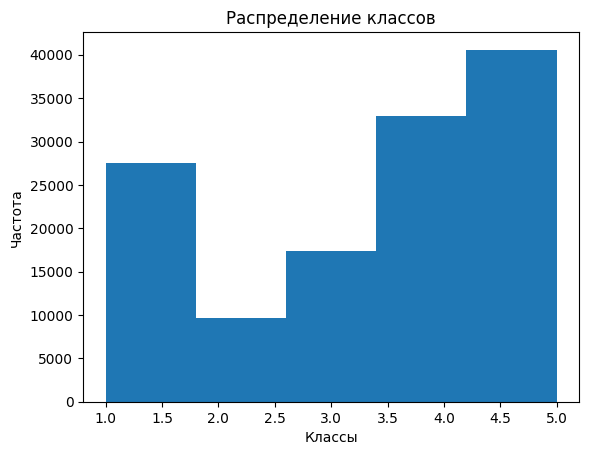

In [9]:
plt.hist(data['rating'], bins=len(data['rating'].unique()))
plt.xlabel('Классы')
plt.ylabel('Частота')
plt.title('Распределение классов')
plt.show()

In [10]:
texts = data['text'].values
labels = data['rating'].values - 1
num_classes = len(np.unique(labels))

In [11]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [12]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.08, stratify=labels, random_state=seed)

tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer)

batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

In [13]:
def train_epoch(model, data_loader, optimizer, loss_function, device):
    model.train()
    losses = []
    correct = 0
    total = 0
    accum_iter = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_function(outputs['logits'], labels)
        loss.backward()
        optimizer.step()
        

        losses.append(loss.item())
        _, predicted = torch.max(outputs['logits'], 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    mean_loss = torch.tensor(losses).mean().item()

    return mean_loss, accuracy

In [14]:
def evaluate(model, data_loader, loss_function, device):
    model.eval()
    losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_function(outputs['logits'], labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs['logits'], 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    mean_loss = torch.tensor(losses).mean().item()

    return mean_loss, accuracy

In [15]:
def train_transformer(trained_model, train_data_loader, val_data_loader, num_epochs, freeze_backbone=True):
    if freeze_backbone:
        trained_model = freeze_backbone_function(trained_model)
        
    trained_model.to(device)

    optimizer = optim.AdamW(trained_model.parameters(), lr=2e-5)
    loss_function = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_epoch(trained_model, train_data_loader, optimizer, loss_function, device)
        val_loss, val_accuracy = evaluate(trained_model, val_data_loader, loss_function, device)
        torch.save(trained_model, f"/kaggle/working/rubert_{epoch}_{val_loss:.4f}_ce.pt")
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {val_loss:.3f}, Valid Acc: {val_accuracy:.2f}%")
    return trained_model


In [16]:
transformer_model = TransformerClassificationModel(model_name, num_classes)

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
model = train_transformer(transformer_model, train_loader, val_loader, num_epochs=1, freeze_backbone=False)

 25%|██▍       | 4830/19626 [1:23:49<4:16:49,  1.04s/it]

In [ ]:
# model = torch.load('/kaggle/working/rubert_1_0.7647_ce.pt', map_location=device)

In [ ]:
test_data = pd.read_csv('/kaggle/input/fiit-nlp-clean/test_clean.csv')
test_texts = test_data['text'].values

In [ ]:
# test_texts1, test_texts = train_test_split(texts, test_size=0.001, stratify=labels, random_state=seed)

In [ ]:
class TextClassificationDataset2(Dataset):
    def __init__(self, texts, tokenizer, max_len=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

In [ ]:
def prediction(model, data_loader, device):
    model.eval()
    _prediction = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs['logits'], 1)
            _prediction.append(predicted)

    return _prediction

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

test_dataset = TextClassificationDataset2(test_texts, tokenizer)

batch_size = 200
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
res = prediction(model, test_loader, device)

In [ ]:
res_2 = torch.concat(res).cpu()

In [ ]:
my_submit = pd.DataFrame({'ID': test_data['ID'].values, 'rating': res_2 + 1})
my_submit

In [ ]:
my_submit['rating'].unique()

In [ ]:
my_submit.to_csv('simp.csv', index=False)